<a href="https://colab.research.google.com/github/Papa-Panda/Paper_reading/blob/main/flow_NICE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# look like: no scale

In [ ]:
# original paper: https://arxiv.org/abs/1410.8516


# discussion
# 细水长flow之NICE：流模型的基本概念与实现
# https://www.spaces.ac.cn/archives/5776


# implementation
# tried https://github.com/bojone/flow/blob/master/nice.py but not working
# https://gemini.google.com/app/64f9247342835580


# my practice
# https://colab.research.google.com/drive/1wN4ouPxI0QM5rChd_8Q5Rg2wdIjYPkGm#scrollTo=tgsGoyXAqujR

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os # For checking if data directory exists

Using device: cuda
Created data directory: ./data


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.83MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.38MB/s]


Starting training...
Epoch 1/20, Loss: 544.4078
Epoch 2/20, Loss: 179.5414
Epoch 3/20, Loss: -170.1320
Epoch 4/20, Loss: -490.5015
Epoch 5/20, Loss: -757.3266
Epoch 6/20, Loss: -961.7318
Epoch 7/20, Loss: -1113.5070
Epoch 8/20, Loss: -1224.7894
Epoch 9/20, Loss: -1306.0871
Epoch 10/20, Loss: -1364.8221
Epoch 11/20, Loss: -1407.6398
Epoch 12/20, Loss: -1445.0868
Epoch 13/20, Loss: -1471.7054
Epoch 14/20, Loss: -1501.2266
Epoch 15/20, Loss: -1517.2599
Epoch 16/20, Loss: -1537.5510
Epoch 17/20, Loss: -1562.0388
Epoch 18/20, Loss: -1576.4288
Epoch 19/20, Loss: -1594.1935
Epoch 20/20, Loss: -1608.1728
Training finished.
Generating 64 samples...


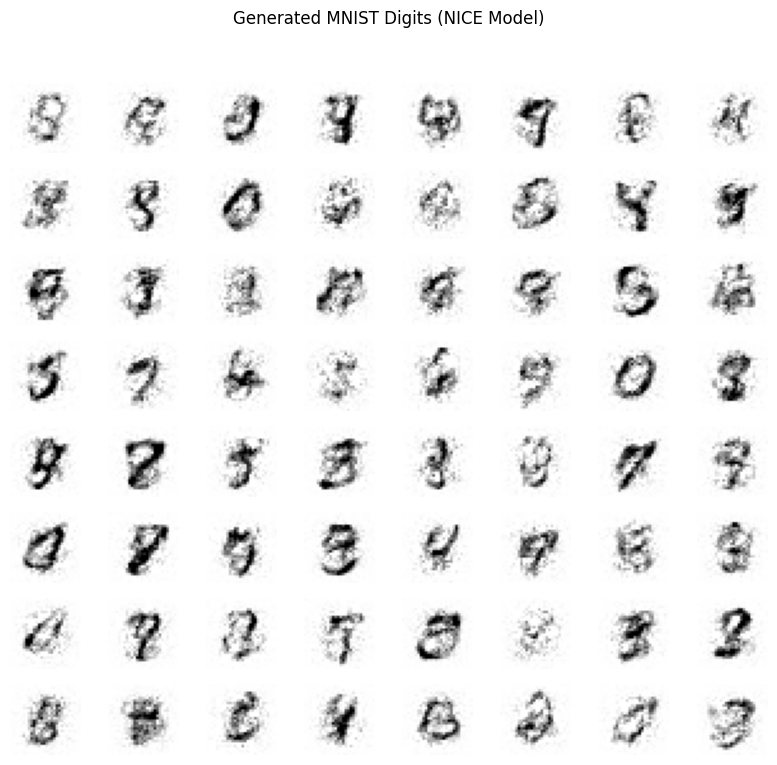

In [ ]:
# --- 1. Data Loading and Preprocessing ---
def load_mnist_data(batch_size=128):
    """
    Loads and preprocesses the MNIST dataset.

    Args:
        batch_size (int): The batch size for the DataLoader.

    Returns:
        tuple: A tuple containing (train_loader, test_loader).
    """
    transform = transforms.Compose([
        transforms.ToTensor(), # Converts PIL Image to PyTorch Tensor and scales to [0, 1]
        # Flatten the 28x28 image to a 784-dimensional vector
        transforms.Lambda(lambda x: x.view(-1)),
        # Add a small amount of uniform noise for dequantization.
        # This is crucial for discrete data (like pixel values) when using
        # continuous normalizing flows. It effectively spreads the discrete
        # pixel values over a continuous interval [0, 1/256) for each pixel.
        # transforms.Lambda(lambda x: x + torch.rand_like(x) / 256.0),
        transforms.Lambda(lambda x: x + 0),
        ])

    # Ensure the data directory exists to store the downloaded MNIST dataset
    data_dir = './data'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        print(f"Created data directory: {data_dir}")

    # Load MNIST training and testing datasets
    train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(data_dir, train=False, download=True, transform=transform)

    # Create DataLoaders for efficient batching and shuffling
    # num_workers > 0 can speed up data loading, especially on GPU
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2 if torch.cuda.is_available() else 0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2 if torch.cuda.is_available() else 0)
    return train_loader, test_loader

# --- 2. Define the Neural Network for the 'm' function in Coupling Layer ---
class CouplingNet(nn.Module):
    """
    A simple multi-layer perceptron (MLP) used within the Additive Coupling Layer.
    This network learns the non-linear transformation 'm(x1)'.
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initializes the CouplingNet.

        Args:
            input_dim (int): Dimension of the input to this network (size of x1).
            hidden_dim (int): Number of units in the hidden layers.
            output_dim (int): Dimension of the output from this network (size of x2).
        """
        super(CouplingNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(), # Activation function
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(), # Activation function
            nn.Linear(hidden_dim, output_dim) # Output dimension matches the size of x2
        )

    def forward(self, x):
        """
        Forward pass for the CouplingNet.

        Args:
            x (torch.Tensor): Input tensor (corresponding to x1 in the coupling layer).

        Returns:
            torch.Tensor: Output tensor (corresponding to m(x1)).
        """
        return self.net(x)

# --- 3. Define the Additive Coupling Layer ---
class AdditiveCouplingLayer(nn.Module):
    """
    An additive coupling layer, a core component of the NICE model.
    It splits the input into two parts, transforms one part based on the other,
    and leaves the other part unchanged. This ensures invertibility and a
    trivial Jacobian determinant.
    """
    def __init__(self, input_dim, hidden_dim, mask_config):
        """
        Initializes an Additive Coupling Layer.

        Args:
            input_dim (int): The total dimension of the input data.
            hidden_dim (int): Hidden dimension for the internal CouplingNet.
            mask_config (int): Determines how the input is split (0 for even indices as x1, 1 for odd).
        """
        super(AdditiveCouplingLayer, self).__init__()
        self.input_dim = input_dim
        self.mask_config = mask_config

        # Create a boolean mask to split the input for the current layer.
        # If mask_config is 0, even-indexed dimensions are x1 (unmodified part),
        # and odd-indexed dimensions are x2 (modified part).
        # If mask_config is 1, odd-indexed dimensions are x1, and even-indexed are x2.
        indices = torch.arange(input_dim)
        if mask_config == 0:
            mask = (indices % 2 == 0).float() # 1s for x1, 0s for x2
        else:
            mask = (indices % 2 != 0).float() # 1s for x1, 0s for x2

        # Register the mask as a buffer so it's moved with the module to the correct device
        self.register_buffer('mask', mask)

        # Determine the dimensions for x1 (input to CouplingNet) and x2 (output from CouplingNet).
        # x1_dim is the number of elements that will be passed to the CouplingNet.
        # x2_dim is the number of elements that will be modified by the CouplingNet's output.
        x1_dim = int(self.mask.sum().item())
        x2_dim = int((1 - self.mask).sum().item())

        # Initialize the internal neural network (m function)
        self.coupling_net = CouplingNet(x1_dim, hidden_dim, x2_dim)

    def forward(self, x, log_det_jacobian):
        """
        Forward pass of the additive coupling layer: y = f(x).

        Args:
            x (torch.Tensor): Input tensor.
            log_det_jacobian (torch.Tensor): Accumulated log-determinant of the Jacobian from previous layers.

        Returns:
            tuple: (output_tensor_y, updated_log_det_jacobian).
        """
        # Ensure the mask is on the same device as the input tensor x
        mask = self.mask.to(x.device)

        # Split x into x1 (unmodified part) and x2 (part to be transformed)
        x1_unmasked = x * mask # Contains x1 values and zeros for x2 positions
        x2_unmasked = x * (1 - mask) # Contains x2 values and zeros for x1 positions

        # Extract the active values for x1 to feed into the coupling network.
        # `mask.bool()` creates a boolean mask for indexing.
        x1_active = x1_unmasked[:, mask.bool()]

        # Compute the output of the coupling network, m(x1)
        coupling_output = self.coupling_net(x1_active)

        # Apply the transformation: y2 = x2 + m(x1)
        # We create a zero tensor with the same shape as x2_unmasked and fill
        # the active (non-masked) positions with the transformed values.
        y2_unmasked = torch.zeros_like(x2_unmasked)
        y2_unmasked[:, (1 - mask).bool()] = x2_unmasked[:, (1 - mask).bool()] + coupling_output

        # Combine y1 (which is just x1) and y2 to form the output y
        y = x1_unmasked + y2_unmasked

        # For additive coupling layers, the Jacobian determinant is 1, so log(det(J)) = 0.
        # Thus, log_det_jacobian remains unchanged by this layer.
        return y, log_det_jacobian

    def inverse(self, y, log_det_jacobian):
        """
        Inverse pass of the additive coupling layer: x = f_inverse(y).

        Args:
            y (torch.Tensor): Input tensor (output from forward pass).
            log_det_jacobian (torch.Tensor): Accumulated log-determinant (not updated here).

        Returns:
            tuple: (output_tensor_x, unchanged_log_det_jacobian).
        """
        # Ensure the mask is on the same device as the input tensor y
        mask = self.mask.to(y.device)

        # Split y into y1 (corresponding to x1) and y2 (corresponding to x2 + m(x1))
        y1_unmasked = y * mask
        y2_unmasked = y * (1 - mask)

        # Extract active values for y1 to feed into the coupling network for inverse calculation
        y1_active = y1_unmasked[:, mask.bool()]

        # Compute m(y1)
        coupling_output = self.coupling_net(y1_active)

        # Apply the inverse transformation: x2 = y2 - m(y1)
        x2_unmasked = torch.zeros_like(y2_unmasked)
        x2_unmasked[:, (1 - mask).bool()] = y2_unmasked[:, (1 - mask).bool()] - coupling_output

        # Combine y1 (which is x1) and x2 to form the original input x
        x = y1_unmasked + x2_unmasked
        return x, log_det_jacobian # log_det_jacobian is not updated during inverse for coupling layer

# --- 4. Define the NICE Model (Flow) ---
class NICE(nn.Module):
    """
    The Non-linear Independent Components Estimation (NICE) model.
    It comprises a stack of additive coupling layers followed by a diagonal scaling layer.
    """
    def __init__(self, input_dim, num_coupling_layers, hidden_dim):
        """
        Initializes the NICE model.

        Args:
            input_dim (int): The dimension of the input data (e.g., 784 for MNIST).
            num_coupling_layers (int): The number of additive coupling layers to stack.
            hidden_dim (int): The hidden dimension for the CouplingNet within each layer.
        """
        super(NICE, self).__init__()
        self.input_dim = input_dim
        self.num_coupling_layers = num_coupling_layers

        # Create a list of additive coupling layers
        self.coupling_layers = nn.ModuleList()
        for i in range(num_coupling_layers):
            # Alternate the mask configuration (0 or 1) for each coupling layer.
            # This ensures that all dimensions of the input data are eventually
            # transformed across the entire flow.
            self.coupling_layers.append(AdditiveCouplingLayer(input_dim, hidden_dim, i % 2))

        # Scaling layer: a learnable diagonal matrix applied at the end.
        # `log_s` stores the log of the scaling factors.
        # Initialized to zeros, meaning initial scaling factors are all 1 (exp(0)=1).
        self.log_s = nn.Parameter(torch.zeros(input_dim))

    def forward(self, x):
        """
        Forward pass of the NICE model: transforms data x to latent variable z.

        Args:
            x (torch.Tensor): Input data tensor.

        Returns:
            tuple: (latent_variable_z, total_log_det_jacobian).
        """
        # Initialize log_det_jacobian for the batch.
        # It accumulates the log-determinant of the Jacobian for the entire transformation.
        log_det_jacobian = torch.zeros(x.size(0)).to(x.device)

        # Pass through all additive coupling layers
        for layer in self.coupling_layers:
            x, log_det_jacobian = layer(x, log_det_jacobian)

        # Apply the final diagonal scaling layer
        # z = x * exp(log_s)
        z = x * torch.exp(self.log_s)

        # Add the log-determinant contribution from the scaling layer.
        # For a diagonal matrix S with diagonal elements s_i, det(S) = product(s_i).
        # So, log(det(S)) = sum(log(s_i)).
        log_det_jacobian += self.log_s.sum()

        return z, log_det_jacobian

    def inverse(self, z):
        """
        Inverse pass of the NICE model: transforms latent variable z back to data x.

        Args:
            z (torch.Tensor): Latent variable tensor.

        Returns:
            torch.Tensor: Reconstructed data tensor x.
        """
        # Inverse of the scaling layer: x_pre_scaling = z / exp(log_s)
        x = z / torch.exp(self.log_s)

        # Inverse through coupling layers in reverse order.
        # For sampling, we typically don't need to compute the log-determinant
        # during the inverse pass, so we pass `None`.
        for layer in reversed(self.coupling_layers):
            x, _ = layer.inverse(x, None) # log_det_jacobian is not needed for inverse here

        return x

    def log_prob(self, x):
        """
        Calculates the log-likelihood of the input data x under the NICE model.

        Args:
            x (torch.Tensor): Input data tensor.

        Returns:
            torch.Tensor: Log-likelihood for each data point in the batch.
        """
        # Transform data x to latent variable z and get the total log-determinant of Jacobian
        z, log_det_jacobian = self.forward(x)

        # Calculate log-probability of z under the prior distribution (standard Gaussian).
        # The prior is assumed to be a standard multivariate Gaussian: N(0, I).
        # log p(z) = -0.5 * torch.sum(z**2 + np.log(2 * np.pi), dim=1)
        # Using torch.sum instead of np.log for consistency with torch tensors
        log_prob_z = -0.5 * torch.sum(z**2 + torch.log(torch.tensor(2 * torch.pi)), dim=1)

        # Apply the change of variables formula to get log p(x):
        # log p(x) = log p(z) + log |det(df/dx)|
        return log_prob_z + log_det_jacobian

    def sample(self, num_samples):
        """
        Generates new data samples from the trained NICE model.

        Args:
            num_samples (int): The number of samples to generate.

        Returns:
            torch.Tensor: Generated data samples.
        """
        # Sample from the prior (standard Gaussian) in the latent space
        z = torch.randn(num_samples, self.input_dim).to(self.log_s.device)
        # Transform these latent samples back to the data space using the inverse flow
        x = self.inverse(z)
        # Clamp values to [0, 1] as original MNIST pixels are in this range
        # (after dequantization and normalization, values might slightly exceed 1)
        x = torch.clamp(x, 0, 1)
        return x

# --- 5. Training Loop ---
def train_nice_model(model, train_loader, optimizer, epochs, device):
    """
    Trains the NICE model using the provided data loader and optimizer.

    Args:
        model (NICE): The NICE model instance.
        train_loader (DataLoader): DataLoader for the training data.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        epochs (int): Number of training epochs.
        device (torch.device): Device to run the training on (CPU or CUDA).
    """
    model.train() # Set the model to training mode
    print("Starting training...")
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device) # Move data to the specified device

            optimizer.zero_grad() # Clear gradients from previous step

            # Calculate the log-likelihood of the data under the model
            log_likelihood = model.log_prob(data)

            # The loss is the negative mean log-likelihood (we want to maximize likelihood)
            loss = -torch.mean(log_likelihood)

            loss.backward() # Backpropagate to compute gradients
            optimizer.step() # Update model parameters

            total_loss += loss.item() # Accumulate loss for reporting

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    print("Training finished.")

# --- 6. Generate Samples and Visualize ---
def generate_samples(model, num_samples=64, img_size=(28, 28), show=True):
    """
    Generates samples from the trained model and visualizes them.

    Args:
        model (NICE): The trained NICE model instance.
        num_samples (int): Number of samples to generate.
        img_size (tuple): Tuple (height, width) for reshaping samples back to image format.
        show (bool): If True, displays the generated samples using matplotlib.

    Returns:
        torch.Tensor: The generated samples.
    """
    model.eval() # Set model to evaluation mode (disables dropout, batchnorm etc. if present)
    print(f"Generating {num_samples} samples...")
    with torch.no_grad(): # Disable gradient calculations during inference/sampling
        samples = model.sample(num_samples).cpu() # Get samples and move them to CPU for plotting
        # Reshape the flattened vectors back into image format (Batch, Channels, Height, Width)
        samples = samples.view(-1, 1, img_size[0], img_size[1])

        if show:
            fig = plt.figure(figsize=(8, 8)) # Create a figure for plotting
            # Determine grid size for subplots (e.g., 8x8 for 64 samples)
            grid_size = int(np.sqrt(num_samples))
            for i in range(num_samples):
                ax = fig.add_subplot(grid_size, grid_size, i + 1)
                # imshow expects (H, W) for grayscale, so squeeze the channel dimension
                ax.imshow(samples[i].squeeze().numpy(), cmap='gray_r') # 'gray_r' for white background
                ax.axis('off') # Turn off axes for cleaner image display
            plt.suptitle('Generated MNIST Digits (NICE Model)') # Set overall title
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
            plt.show() # Display the plot
        return samples

# --- Main execution block ---
if __name__ == "__main__":
    # --- Hyperparameters ---
    INPUT_DIM = 28 * 28  # Dimension of flattened MNIST images (784 pixels)
    HIDDEN_DIM = 1000   # Size of hidden layers within the CouplingNet (can be tuned)
    NUM_COUPLING_LAYERS = 8 # Number of additive coupling layers in the flow (can be tuned)
    BATCH_SIZE = 128    # Number of samples per training batch
    EPOCHS = 20         # Number of training iterations over the entire dataset (can be increased)
    LEARNING_RATE = 1e-3 # Learning rate for the Adam optimizer

    # --- Device Configuration ---
    # Check if CUDA (GPU) is available, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Load Data ---
    # Get training and testing data loaders
    train_loader, _ = load_mnist_data(BATCH_SIZE)

    # --- Initialize Model and Optimizer ---
    # Create an instance of the NICE model and move it to the selected device
    model = NICE(INPUT_DIM, NUM_COUPLING_LAYERS, HIDDEN_DIM).to(device)
    # Use Adam optimizer for training the model parameters
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # --- Train the Model ---
    train_nice_model(model, train_loader, optimizer, EPOCHS, device)

    # --- Generate and Visualize Samples ---
    # Generate 64 samples and display them
    generate_samples(model, num_samples=64)

In [ ]:
# new version from https://gemini.google.com/app/07d315b6f26a7541

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Model Components ---

class AdditiveCouplingLayer(nn.Module):
    """
    This layer implements the additive coupling transformation.
    It splits the input into two halves. One half is used to compute a translation
    for the other half. This version is corrected to properly handle tensor dimensions.
    """
    def __init__(self, in_out_dim, mid_dim, hidden_layers):
        super(AdditiveCouplingLayer, self).__init__()
        self.in_out_dim = in_out_dim

        # The neural network that computes the translation.
        # It always takes one half of the input vector and outputs a translation for the other half.
        modules = [nn.Linear(in_out_dim // 2, mid_dim), nn.ReLU()]
        for _ in range(hidden_layers - 1):
            modules.append(nn.Linear(mid_dim, mid_dim))
            modules.append(nn.ReLU())
        modules.append(nn.Linear(mid_dim, in_out_dim // 2))
        self.m = nn.Sequential(*modules)

    def forward(self, x, mask, reverse=False):
        """
        Forward and reverse pass of the additive coupling layer.
        - `x`: input tensor
        - `mask`: a binary mask to select which part of the input to keep unchanged
        - `reverse`: if True, performs the inverse transformation
        """
        # The mask determines which half is unchanged (x1) and which is transformed (x2).
        is_first_half_unchanged = mask[0] == 1

        if is_first_half_unchanged:
            x1, x2 = x[:, :self.in_out_dim // 2], x[:, self.in_out_dim // 2:]
        else: # Second half is unchanged
            x2, x1 = x[:, :self.in_out_dim // 2], x[:, self.in_out_dim // 2:]

        # The network `m` computes the translation based on the unchanged part `x1`.
        translation = self.m(x1)

        if not reverse:
            y2 = x2 + translation
        else: # reverse pass
            y2 = x2 - translation

        # Re-assemble the vector in the original order.
        if is_first_half_unchanged:
            return torch.cat((x1, y2), dim=1)
        else:
            return torch.cat((y2, x1), dim=1)

class ScalingLayer(nn.Module):
    """
    This layer performs a learnable scaling of the input.
    """
    def __init__(self, dim):
        super(ScalingLayer, self).__init__()
        self.scale = nn.Parameter(torch.zeros(1, dim), requires_grad=True)

    def forward(self, x, reverse=False):
        log_det_J = torch.sum(self.scale)
        if not reverse:
            x = x * torch.exp(self.scale)
        else:
            x = x * torch.exp(-self.scale)
        return x, log_det_J

# --- 2. NICE Model ---

class NICE(nn.Module):
    """
    The full NICE model, which is a sequence of coupling layers and a final scaling layer.
    """
    def __init__(self, in_out_dim, mid_dim, hidden_layers, num_coupling_layers):
        super(NICE, self).__init__()
        self.in_out_dim = in_out_dim
        self.coupling_layers = nn.ModuleList()

        # Create the coupling layers with alternating masks
        for i in range(num_coupling_layers):
            mask = torch.zeros(in_out_dim, device=device)
            # Alternate which half of the input is unchanged
            if i % 2 == 0:
                mask[:in_out_dim // 2] = 1 # First half is unchanged
            else:
                mask[in_out_dim // 2:] = 1 # Second half is unchanged

            self.coupling_layers.append(AdditiveCouplingLayer(in_out_dim, mid_dim, hidden_layers))
            self.register_buffer(f"mask_{i}", mask)

        self.scaling_layer = ScalingLayer(in_out_dim)

    def forward(self, x):
        """
        Forward pass (from data to latent space).
        This is used for training.
        """
        log_det_J = 0
        for i, layer in enumerate(self.coupling_layers):
            mask = getattr(self, f"mask_{i}")
            x = layer(x, mask)

        x, log_det_J_scaling = self.scaling_layer(x)
        log_det_J += log_det_J_scaling
        return x, log_det_J

    def inverse(self, z):
        """
        Inverse pass (from latent space to data).
        This is used for sampling.
        """
        x, _ = self.scaling_layer(z, reverse=True)
        for i, layer in reversed(list(enumerate(self.coupling_layers))):
            mask = getattr(self, f"mask_{i}")
            x = layer(x, mask, reverse=True)
        return x

# --- 3. Data Loading and Preprocessing ---

def load_mnist(batch_size):
    """
    Loads and preprocesses the MNIST dataset.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x.view(-1) # Flatten the images
    ])

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# --- 4. Loss Function ---

def loss_function(z, log_det_J):
    """
    Calculates the negative log-likelihood of the data.
    The prior distribution for the latent space is a standard normal distribution.
    """
    # Log-likelihood of the latent variable z under the prior
    log_p_z = -0.5 * torch.sum(z**2, dim=1) - 0.5 * z.shape[1] * np.log(2 * np.pi)

    # Total log-likelihood
    log_likelihood = log_p_z + log_det_J

    # Return the negative log-likelihood (to be minimized)
    return -torch.mean(log_likelihood)

# --- 5. Training Loop ---

def train(model, train_loader, optimizer, epoch, dequantize=True):
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        # Dequantization by adding uniform noise
        if dequantize:
            data += torch.rand_like(data) / 256.0

        optimizer.zero_grad()
        z, log_det_J = model(data)
        loss = loss_function(z, log_det_J)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.4f}')

    return total_loss / len(train_loader)

def test(model, test_loader, epoch, dequantize=True):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            if dequantize:
                data += torch.rand_like(data) / 256.0
            z, log_det_J = model(data)
            loss = loss_function(z, log_det_J)
            total_loss += loss.item()

    print(f'\nTest set, Epoch {epoch}: Average loss: {total_loss / len(test_loader):.4f}\n')
    return total_loss / len(test_loader)


# --- 6. Sampling and Visualization ---

def sample_and_visualize(model, num_samples=64, epoch=None):
    """
    Generates samples from the model and visualizes them.
    """
    model.eval()
    with torch.no_grad():
        # Sample from the prior (standard normal)
        z = torch.randn(num_samples, 784).to(device)

        # Generate samples by passing through the inverse model
        generated_samples = model.inverse(z)
        generated_samples = generated_samples.view(num_samples, 1, 28, 28).cpu()

        # Create a grid of images
        fig, axes = plt.subplots(8, 8, figsize=(8, 8))
        for i, ax in enumerate(axes.flat):
            ax.imshow(generated_samples[i].squeeze(), cmap='gray')
            ax.axis('off')

        if epoch is not None:
            plt.suptitle(f'Generated Samples at Epoch {epoch}')
        else:
            plt.suptitle('Generated Samples')

        # Save the figure
        if not os.path.exists('samples'):
            os.makedirs('samples')
        if epoch is not None:
            plt.savefig(f'samples/epoch_{epoch}.png')
        else:
            plt.savefig('samples/final_samples.png')
        plt.close()

# --- Main Execution ---

if __name__ == '__main__':
    # Hyperparameters
    BATCH_SIZE = 128
    EPOCHS = 20
    LEARNING_RATE = 1e-3
    IN_OUT_DIM = 784  # 28x28 for MNIST
    MID_DIM = 1024
    HIDDEN_LAYERS = 2
    NUM_COUPLING_LAYERS = 4

    # Load data
    train_loader, test_loader = load_mnist(BATCH_SIZE)

    # Initialize model and optimizer
    model = NICE(
        in_out_dim=IN_OUT_DIM,
        mid_dim=MID_DIM,
        hidden_layers=HIDDEN_LAYERS,
        num_coupling_layers=NUM_COUPLING_LAYERS
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("Starting training...")
    for epoch in range(1, EPOCHS + 1):
        train(model, train_loader, optimizer, epoch)
        test(model, test_loader, epoch)
        sample_and_visualize(model, epoch=epoch)

    print("Training finished.")

    # Save the final model
    torch.save(model.state_dict(), 'nice_mnist_model.pth')

    # Generate and visualize final samples
    sample_and_visualize(model)
    print("Final samples saved to samples/final_samples.png")


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 454kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.73MB/s]


Starting training...
Train Epoch: 1 [0/60000] Loss: 768.0862
Train Epoch: 1 [12800/60000] Loss: 654.7681
Train Epoch: 1 [25600/60000] Loss: 572.6774
Train Epoch: 1 [38400/60000] Loss: 494.0948
Train Epoch: 1 [51200/60000] Loss: 416.3398

Test set, Epoch 1: Average loss: 362.3265

Train Epoch: 2 [0/60000] Loss: 362.2703
Train Epoch: 2 [12800/60000] Loss: 284.6472
Train Epoch: 2 [25600/60000] Loss: 210.4108
Train Epoch: 2 [38400/60000] Loss: 134.5391
Train Epoch: 2 [51200/60000] Loss: 60.1356

Test set, Epoch 2: Average loss: 10.1457

Train Epoch: 3 [0/60000] Loss: 8.5218
Train Epoch: 3 [12800/60000] Loss: -62.9637
Train Epoch: 3 [25600/60000] Loss: -130.5522
Train Epoch: 3 [38400/60000] Loss: -201.4272
Train Epoch: 3 [51200/60000] Loss: -266.5598

Test set, Epoch 3: Average loss: -314.8924

Train Epoch: 4 [0/60000] Loss: -318.0709
Train Epoch: 4 [12800/60000] Loss: -381.6828
Train Epoch: 4 [25600/60000] Loss: -437.8432
Train Epoch: 4 [38400/60000] Loss: -502.8050
Train Epoch: 4 [51200/6

In [2]:
# Hyperparameters
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 1e-3
IN_OUT_DIM = 784  # 28x28 for MNIST
MID_DIM = 1024
HIDDEN_LAYERS = 2
NUM_COUPLING_LAYERS = 4

# Load data
train_loader, test_loader = load_mnist(BATCH_SIZE)

# Initialize model and optimizer
model = NICE(
    in_out_dim=IN_OUT_DIM,
    mid_dim=MID_DIM,
    hidden_layers=HIDDEN_LAYERS,
    num_coupling_layers=NUM_COUPLING_LAYERS
).to(device)

# 2. Load the saved state dictionary
# This loads your trained weights and biases into the model instance.
model.load_state_dict(torch.load('nice_mnist_model.pth'))


<All keys matched successfully>

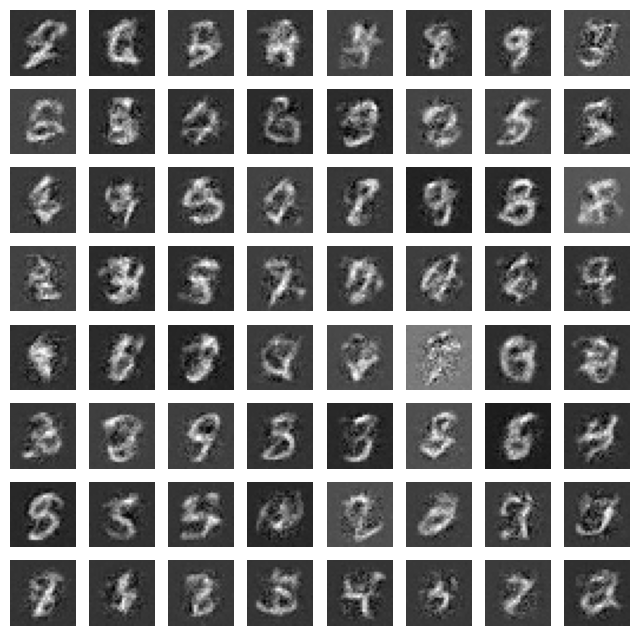

In [22]:
num_samples=64
img_size=(28, 28)
show=True
model.eval() # Set model to evaluation mode (disables dropout, batchnorm etc. if present)


model.eval()
with torch.no_grad():
    # Sample from the prior (standard normal)
    z = torch.randn(num_samples, 784).to(device)

    # Generate samples by passing through the inverse model
    generated_samples = model.inverse(z)
    generated_samples = generated_samples.view(num_samples, 1, 28, 28).cpu()

    # Create a grid of images
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_samples[i].squeeze(), cmap='gray')
        ax.axis('off')

# with torch.no_grad(): # Disable gradient calculations during inference/sampling
#     samples = model.sample(num_samples).cpu() # Get samples and move them to CPU for plotting
#     # Reshape the flattened vectors back into image format (Batch, Channels, Height, Width)
#     samples = samples.view(-1, 1, img_size[0], img_size[1])

#     if show:
#         fig = plt.figure(figsize=(8, 8)) # Create a figure for plotting
#         # Determine grid size for subplots (e.g., 8x8 for 64 samples)
#         grid_size = int(np.sqrt(num_samples))
#         for i in range(num_samples):
#             ax = fig.add_subplot(grid_size, grid_size, i + 1)
#             # imshow expects (H, W) for grayscale, so squeeze the channel dimension
#             ax.imshow(samples[i].squeeze().numpy(), cmap='gray_r') # 'gray_r' for white background
#             ax.axis('off') # Turn off axes for cleaner image display
#         plt.suptitle('Generated MNIST Digits (NICE Model)') # Set overall title
#         plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
#         plt.show() # Display the plot